In [42]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [43]:
img  = nib.load('/Users/ata/Desktop/vision/BLG453/term project/part4/V.nii').dataobj
gt = nib.load('/Users/ata/Desktop/vision/BLG453/term project/part4/V_seg.nii').dataobj

In [44]:
def dice_score(seg,gt,eps = 0.0000001):
    dice = ((np.sum(seg[gt==1])*2.0)+eps) / (np.sum(seg) + np.sum(gt)+eps)
    return dice
def seed_selector(img,th = 3):
    img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)[1] # to select best points
    seeds=[]
    w = 10
    h = 20
    w_size =10
    for i in range (w_size) :
        window = img[h*(i):h*(i+1),w*(i):w*(i+1)]
        temp = np.sum(window)
        inds = np.where(window > 250)
        if len(inds[0]) > th:         
            y = inds[0][0]+ (h*(i)) 
            x = inds[1][0]+ (w*(i)) 
            seeds.append((y,x))
    return seeds

In [45]:
def region_grow(img, seeds, points,th = 70,offset=220):
    h,w = img.shape
    seg_map = np.zeros(img.shape)
    c= 0
    img = np.int16(img)
    while(len(seeds)>0):
        pt = seeds.pop(0)
        seg_map[pt] =1
        for i in range(len(points)):
            y = pt[0] + points[i][0]
            x = pt[1] + points[i][1]
            if y < 0 or x < 0 or y >= h or x >= w:
                continue
            diff = np.abs(np.subtract(img[pt], img[y,x]))
            # print(diff)            
            if img[y,x] > offset  and diff < th  and seg_map[y,x] == 0: #
                seg_map[y,x] = 1
                seeds.append((y,x))
                c+=1
                #print(img[pt],img[y,x] , diff)
                diff = 0
    # print(c)
    return seg_map
    

In [46]:
gt = np.array(gt)
for i in range(img.shape[2]):
    if i ==0:
        a = gt[:,:,i].flatten()
    else :
        a = np.concatenate((a,gt[:,:,i].flatten()),axis = None)


In [47]:
points_4 = [ (0, -1), (1, 0),(0, 1), (-1, 0)]
points_8 = [(0, -1), (1, 0),(0, 1), (-1, 0),(1,1),(-1,-1),(1,-1),(-1,1) ]
def calculate(img,points,th):
    label_list = []
    for i in range(img.shape[2]):
        den = np.uint8(img[:,:,i]*255)
        dst = cv2.bilateralFilter(den,9,100,100)
        empty = np.where(dst<127)
        dst[empty]=0   
        seeds = seed_selector(dst)
        if seeds == []:        
            labels = np.zeros(dst.shape) #if empty         
        else:
            labels = region_grow(dst,seeds,points,offset= 140,th = th)
        if i ==0:
            b = labels.flatten()
        else :
            b = np.concatenate((b,labels.flatten()),axis = None)
        label_list.append(labels)
    return b,label_list

In [48]:
label_4,labels_4 = calculate(img,points_4,20)
label_8,labels_8 = calculate(img,points_8,20)

In [49]:
score_4 = dice_score(a,label_4)
score_8 = dice_score(a,label_8)
print('4 neighboor score is: ',score_4)
print('8 neighboor score is: ',score_8)

4 neighboor score is:  0.9113288343835363
8 neighboor score is:  0.9143787398805122


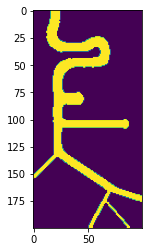

In [116]:
plt.imshow(gt[:,:,49])

plt.show()

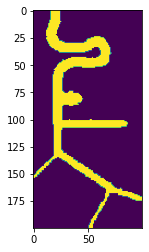

In [117]:
plt.imshow(labels_4[49])

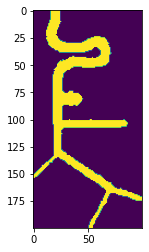

In [118]:
plt.imshow(labels_8[49])

In [51]:
nif4= nib.Nifti1Image(np.array(labels_4), affine=np.eye(4))
nif8= nib.Nifti1Image(np.array(labels_8), affine=np.eye(4))
nib.save(nif4,'connectivity4.nii')
nib.save(nif8,'connectivity8.nii')

# 3D 

In [4]:
img_org  = nib.load('/Users/ata/Desktop/vision/BLG453/term project/part4/V.nii').dataobj
gt = nib.load('/Users/ata/Desktop/vision/BLG453/term project/part4/V_seg.nii').dataobj

In [21]:
def region_grow3d(img, seeds, points,th = 20, offset= 130):
    h,w,d = img.shape
    seg_map = np.zeros(img.shape)
    img = np.int16(img)
    while(len(seeds)>0):
        pt = seeds.pop(0)
        seg_map[pt] =1
        for i in range(len(points)):
            y = pt[0] + points[i][0]
            x = pt[1] + points[i][1]
            z = pt[2] + points[i][2]
            if y < 0 or x < 0 or z < 0 or y >= h or x >= w or z >=d:
                continue
            diff = img[pt] - img[y,x,z]
            if img[y,x,z] > offset  and diff < th and  seg_map[y,x,z] == 0:
                seg_map[y,x,z] = 1
                seeds.append((y,x,z))
    return seg_map
def seed_selector3d(img,th = 10):
    h_img,w_img,d_img = img.shape
    seeds=[]
    w = 10
    h = 20
    d = 5 
    seed_number =5
    w_size = 10
    for i in range (d_img//d) :
        window = img[:,:,d*(i):d*(i+1)]
        inds = np.where(window == 255)
        for j in range(len(inds[0])):
            y = inds[0][0] 
            x = inds[1][0]
            z = inds[2][0]+ (d*(i))
            if y+w_size < h_img and x+w_size < w_img:
                tmp = np.sum(img[y:y+w_size, x: x+ w_size])
                if tmp > th: 
                    seeds.append((y,x,z))
                break 
        if len(seeds) == seed_number:
            break
        
    return seeds
def flatter(img):
    img = np.array(img)
    for i in range(img.shape[2]):
        if i ==0:
            a = img[:,:,i].flatten()
        else :
            a = np.concatenate((a,img[:,:,i].flatten()),axis = None)
    return a

In [10]:
# POINTS
points_6 = [(1,0,0),(0,1,0),(0,0,1),(-1,0,0),(0,-1,0),(0,0,-1)]
points_26 = []
for y in range(-1,2):
    for x in range(-1,2):
        for z in range(-1,2):
            if (y,x,z)!= (0,0,0):
                points_26.append((y,x,z))

In [27]:
def calculate_3d(img,points,th):
    for z in range(img.shape[2]):
        img[:,:,z] = cv2.bilateralFilter(img[:,:,z],9,100,100)    
    seeds = seed_selector3d(img)
    labels = region_grow3d(img,seeds,points,th= th)
    return labels


In [33]:
img = np.uint8(img_org[:]*255)
labels_6 = calculate_3d(img,points_6,20)
img = np.uint8(img_org[:]*255)
labels_26 = calculate_3d(img,points_26,20)


In [34]:
flat_gt = flatter(gt)
flat_6 = flatter(labels_6)
flat_26 = flatter(labels_26)

score_6= dice_score(flat_6,flat_gt)
score_26 =dice_score(flat_26,flat_gt)
print('Score with 6 connectivity', score_6)
print('Score with 26 connectivity', score_26)

Score with 6 connectivity 0.9109451120495595
Score with 26 connectivity 0.8925217247716215


In [38]:
nif6= nib.Nifti1Image(labels_6, affine=np.eye(4))
nif26= nib.Nifti1Image(labels_26, affine=np.eye(4))
nib.save(nif6,'connectivity6.nii')
nib.save(nif26,'connectivity26.nii')